In [1]:
#importing all the packages and modelus needed
import pandas as pd
import numpy as np
import xgboost as xgb
import missingno as msno
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, \
accuracy_score, recall_score, precision_score
from sklearn.feature_selection import SelectFromModel
from xgboost import plot_importance

In [2]:
#loading the data
X = pd.read_csv("train.csv", header=None)
y = pd.read_csv("train_labels.csv", header=None)
val_data = pd.read_csv("test.csv", header=None)
final_df = pd.read_csv("test.csv", header=None)

In [3]:
X.info() #overview of the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20468 entries, 0 to 20467
Columns: 112 entries, 0 to 111
dtypes: float64(89), int64(23)
memory usage: 17.5 MB


In [4]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812 entries, 0 to 1811
Columns: 112 entries, 0 to 111
dtypes: float64(89), int64(23)
memory usage: 1.5 MB


In [5]:
#replacing the class '2' to class '1'
y[0] = y[0].replace(2, 1) 
y = pd.Series(y[0])
print(y.unique())

[1 0]


In [6]:
#check how many columns have just 0 values
print(X.loc[:,X.sum() == 0].shape[1]) 
print(val_data.loc[:,val_data.sum() == 0].shape[1])

15
18


In [7]:
#check the indeces of zero-columns from val_data that are not empty in X dataframe
temp = pd.Series(X.sum() == 0) == (val_data.sum() == 0)
print(temp[temp.isin([False])].index)

Int64Index([72, 73, 74], dtype='int64')


In [8]:
#since the val_data set has more zero-columns we have to remove just those columns that are equal for both dataframes
val_data = val_data.loc[:,X.sum() != 0]
X = X.loc[:,X.sum() != 0]

print(X.shape[1] == val_data.shape[1]) #check if the number of columns is the same

True


UnboundLocalError: local variable 'ax2' referenced before assignment

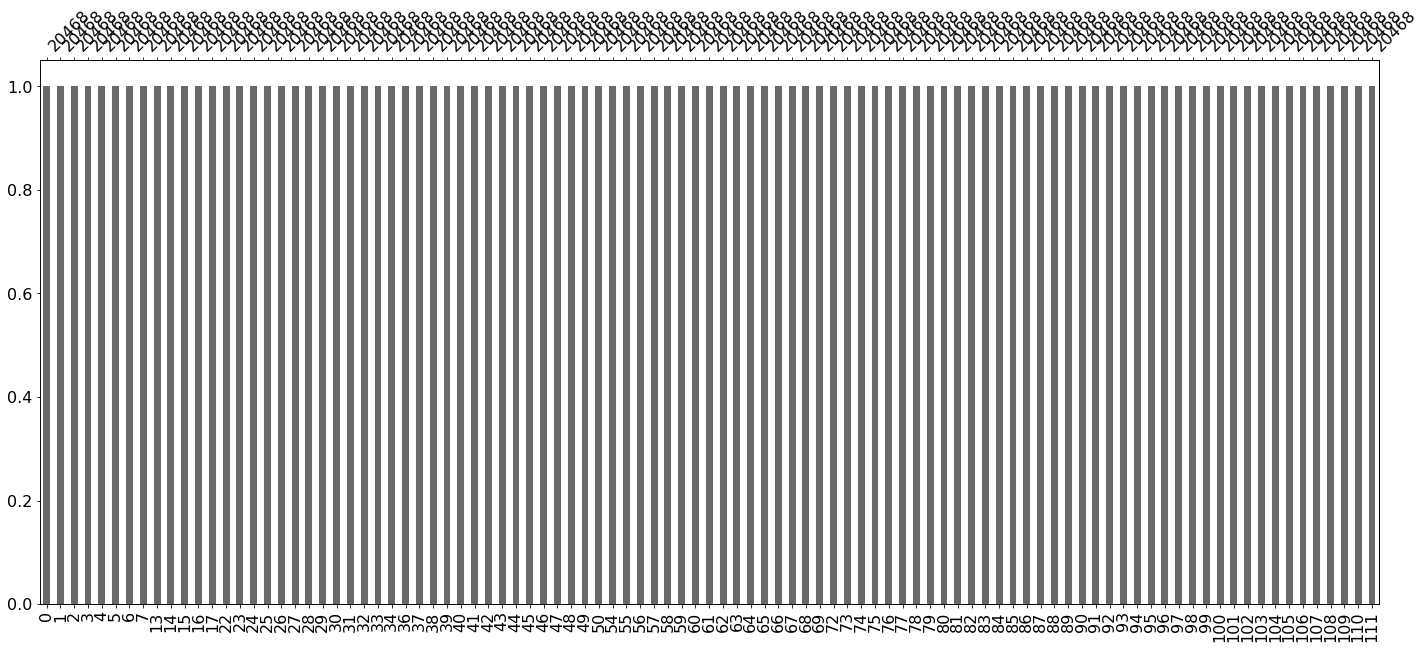

In [9]:
#checking for missing values
msno.bar(X)

UnboundLocalError: local variable 'ax2' referenced before assignment

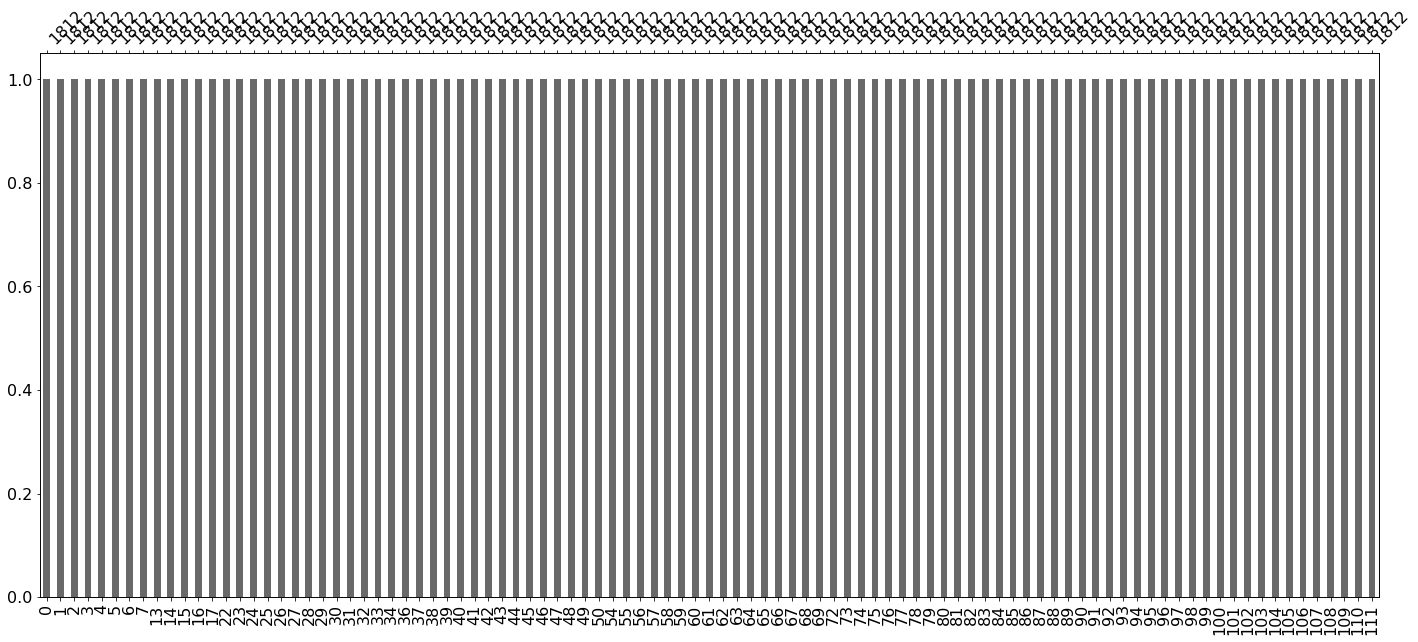

In [10]:
msno.bar(val_data)

In [11]:
y.isnull().sum()

0

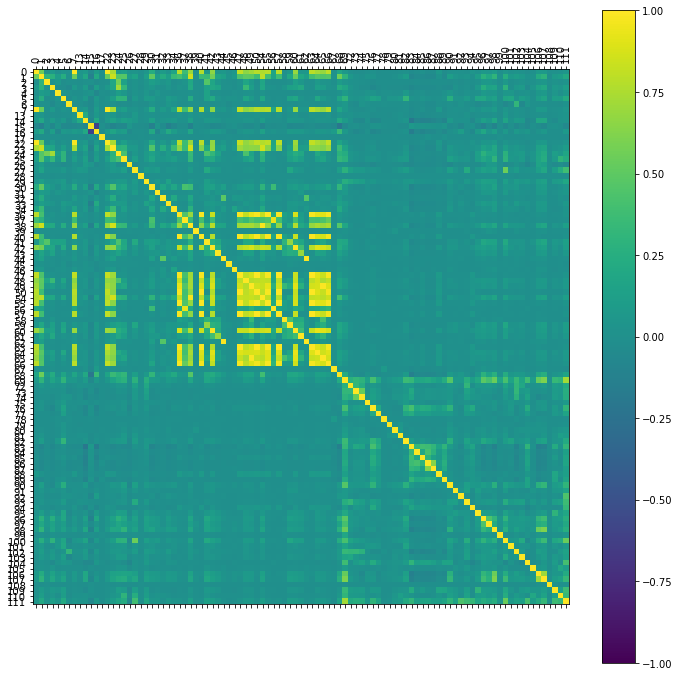

In [12]:
#plot the correlation matrix
correlations = X.corr() #matrix of correlation values
fig = plt.figure(figsize=(12,12)) #set the plot size
ax = fig.add_subplot(111) 
cax = ax.matshow(correlations, vmin=-1, vmax=1) #bar with correlation legend [-1, 1]
fig.colorbar(cax)
ticks = np.arange(0,X.shape[1],1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.xticks(rotation=90)
ax.set_xticklabels(X.columns.values.tolist())
ax.set_yticklabels(X.columns.values.tolist())
plt.show()

In [13]:
#defining a funtion that removes correlated columns from DF
def correlation(dataset, threshold):
    corr_matrix = dataset.corr().abs() #matrix of absolute correlation values
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold: #check if correlation if higher than given number
                colname = corr_matrix.columns[i] # getting the name of column
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

X_cleaned = X.copy() #copy X DF to a new one
correlation(X_cleaned, 0.9) #remove those columns that have correlation higher than 0.9

#check how many columns were deleted
print("Number of columns in old DF: %i" % X.shape[1])
print("Number of columns in new DF: %i" % X_cleaned.shape[1])

Number of columns in old DF: 97
Number of columns in new DF: 81


In [14]:
#remove correlated columns for val_data DF
val_data_cleaned = val_data.loc[:, X_cleaned.columns]

In [15]:
#split X DF into train/test sets (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.25, random_state=123)

In [16]:
#train the simple Extreme Gradient Boosting Classifier model
xgb_model_0 = xgb.XGBClassifier(objective='binary:logistic', seed=123) 
xgb_model_0.fit(X_train, y_train) #train the model on train set
y_pred = xgb_model_0.predict(X_test) #predict on test set
print(classification_report(y_test, y_pred)) #print the performance
print('\nAccuracy score: %.2f' % accuracy_score(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.94      0.97      0.95      3775
          1       0.89      0.82      0.85      1342

avg / total       0.93      0.93      0.93      5117


Accuracy score: 0.93


We are interested in Precision (>= 95%) and Recall (AHAP) of class 1 prediction. Right now they are equal to: 

Precision = 0.89
Recall = 0.82

So we need to tune the model to improve performance. I will use Grid Searching which is scanning the data to configure optimal parameters for a given model.

In [17]:
#defining the model for fitting a model with grid search matrix as parameter
def model_fitting(grid):
    y_pred = []
    model = []
    temp = []
    #set 'precision' to check which values return the highest precision level
    model = GridSearchCV(estimator=xgb.XGBClassifier(seed=123), param_grid=grid,
                         scoring='precision', verbose=True) 
    model.fit(X_train, y_train)
    print("Best parameters found: ", model.best_params_) #print the best parameters
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

In [18]:
#finding the best parameter of subsample ratio of columns
gbm_param_grid = {
    'colsample_bytree': [0.2, 0.5, 1]
}
model_fitting(gbm_param_grid) #call for function

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   24.0s finished


Best parameters found:  {'colsample_bytree': 0.2}
             precision    recall  f1-score   support

          0       0.93      0.96      0.95      3775
          1       0.89      0.80      0.84      1342

avg / total       0.92      0.92      0.92      5117



In [19]:
#finding the best parameter of maximum tree depth
gbm_param_grid = {
    'colsample_bytree': [0.2],
    'max_depth': [3, 7, 10]
}
model_fitting(gbm_param_grid)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   26.7s finished


Best parameters found:  {'colsample_bytree': 0.2, 'max_depth': 10}
             precision    recall  f1-score   support

          0       0.94      0.98      0.96      3775
          1       0.92      0.83      0.87      1342

avg / total       0.94      0.94      0.94      5117



In [20]:
#finding the best parameter of boosting learning rate
gbm_param_grid = {
    'colsample_bytree': [0.2],
    'max_depth': [10],
    'learning_rate': [0.01, 0.1, 1]
}
model_fitting(gbm_param_grid)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   39.4s finished


Best parameters found:  {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 10}
             precision    recall  f1-score   support

          0       0.90      0.99      0.94      3775
          1       0.96      0.69      0.80      1342

avg / total       0.92      0.91      0.91      5117



In cell 21 we could see that Precision was 0.92 with Learning Rate at default (=0.1), but after changing it to 0.01 Precision increased to 0.96. Recall was decreased significantly. So lets look deeper fot better Learning Rate parameter within the range [0.01, 0.1]

In [21]:
gbm_param_grid = {
    'colsample_bytree': [0.2],
    'max_depth': [10],
    'learning_rate': [0.05]
}
model_fitting(gbm_param_grid)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.7s finished


Best parameters found:  {'colsample_bytree': 0.2, 'learning_rate': 0.05, 'max_depth': 10}
             precision    recall  f1-score   support

          0       0.93      0.98      0.95      3775
          1       0.93      0.79      0.85      1342

avg / total       0.93      0.93      0.93      5117



In [22]:
gbm_param_grid = {
    'colsample_bytree': [0.2],
    'max_depth': [10],
    'learning_rate': [0.025]
}
model_fitting(gbm_param_grid)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.3s finished


Best parameters found:  {'colsample_bytree': 0.2, 'learning_rate': 0.025, 'max_depth': 10}
             precision    recall  f1-score   support

          0       0.91      0.99      0.95      3775
          1       0.95      0.73      0.83      1342

avg / total       0.92      0.92      0.92      5117



In [23]:
#finding the best parameter of number of boosted trees to fit
gbm_param_grid = {
    'colsample_bytree': [0.2],
    'max_depth': [10],
    'learning_rate': [0.025],
    'n_estimators':[100, 200, 500]
}
model_fitting(gbm_param_grid)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.8min finished


Best parameters found:  {'colsample_bytree': 0.2, 'learning_rate': 0.025, 'max_depth': 10, 'n_estimators': 100}
             precision    recall  f1-score   support

          0       0.91      0.99      0.95      3775
          1       0.95      0.73      0.83      1342

avg / total       0.92      0.92      0.92      5117



In [24]:
#finding the best parameter of minimum sum of instance weight needed in a child
gbm_param_grid = {
    'colsample_bytree': [0.2],
    'max_depth': [10],
    'learning_rate': [0.025],
    'n_estimators':[100],
    'min_child_weight':[1, 5, 10]
}
model_fitting(gbm_param_grid)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   37.8s finished


Best parameters found:  {'colsample_bytree': 0.2, 'learning_rate': 0.025, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100}
             precision    recall  f1-score   support

          0       0.91      0.99      0.95      3775
          1       0.95      0.73      0.83      1342

avg / total       0.92      0.92      0.92      5117



In [25]:
#finding the best parameter of minimum sum of subsample ratio of the training instance
gbm_param_grid = {
    'colsample_bytree': [0.2],
    'max_depth': [10],
    'learning_rate': [0.025],
    'n_estimators':[100],
    'min_child_weight':[1],
    'subsample': [0.3, 0.5, 1]
}
model_fitting(gbm_param_grid)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   38.0s finished


Best parameters found:  {'colsample_bytree': 0.2, 'learning_rate': 0.025, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1}
             precision    recall  f1-score   support

          0       0.91      0.99      0.95      3775
          1       0.95      0.73      0.83      1342

avg / total       0.92      0.92      0.92      5117



In [26]:
#finding the best parameter of L1 regularization term on weights
gbm_param_grid = {
    'colsample_bytree': [0.2],
    'max_depth': [10],
    'learning_rate': [0.025],
    'n_estimators': [100],
    'min_child_weight': [1],
    'subsample': [1],
    'reg_alpha': [0, 0.001, 0.01, 0.5]
}
model_fitting(gbm_param_grid)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   52.0s finished


Best parameters found:  {'colsample_bytree': 0.2, 'learning_rate': 0.025, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.5, 'subsample': 1}
             precision    recall  f1-score   support

          0       0.91      0.99      0.95      3775
          1       0.95      0.73      0.83      1342

avg / total       0.92      0.92      0.92      5117



In [28]:
""" The best precision/recall values for class 1 were obtained with the next parameters:
{'colsample_bytree': 0.2, 'learning_rate': 0.025, 'max_depth': 10, 'min_child_weight': 1, 
'n_estimators': 100, 'reg_alpha': 0.5, 'subsample': 1}
Building the final model with these parameters
"""

xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                              colsample_bytree=0.2,
                              max_depth=10,
                              learning_rate=0.025,
                              min_child_weight=1,
                              n_estimators=100,
                              reg_alpha=0.5,
                              subsample=1,
                              seed=123                              
                             )
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.91      0.99      0.95      3775
          1       0.95      0.73      0.83      1342

avg / total       0.92      0.92      0.92      5117

[[3723   52]
 [ 357  985]]


The next step is to check wether the performance can be improved by removing the variables that are not important for model prediction.

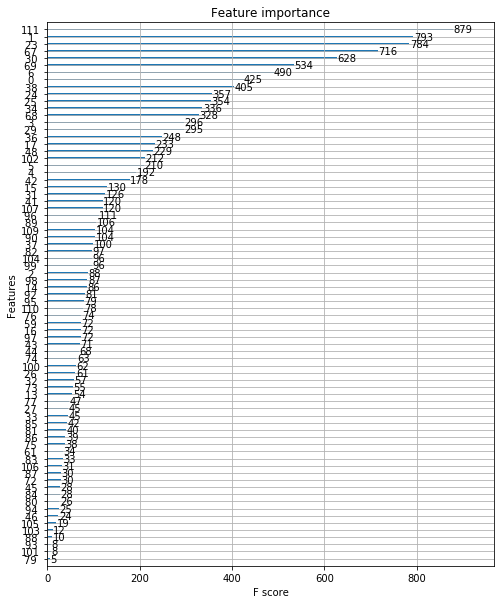

In [29]:
plt.rcParams['figure.figsize'] = [8, 10] #set the size of the plot
plot_importance(xgb_model) #calling the function that returns the importance values
plt.show()

In [30]:
#creating an array with sorted values of importance values
thresholds = np.sort(xgb_model_0.feature_importances_) 

#creating a DF wich will hold information about number of variables and precision and recall values related to it
selection_df = pd.DataFrame({'Thresh':[], 'n':[], 'Precision':[], 'Recall':[]})

In [31]:
for thresh in tqdm(thresholds): #tqdm funtion visualizes the loading percantage
    #select features using threshold
    selection = SelectFromModel(xgb_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train) 
    select_xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                                         colsample_bytree=0.2,
                                         max_depth=10,
                                         learning_rate=0.025,
                                         min_child_weight=1,
                                         n_estimators=100,
                                         reg_alpha=0.5,
                                         subsample=1,
                                         seed=123  
                                        )
    select_xgb_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_test)
    y_pred_s = select_xgb_model.predict(select_X_test)
    #writing data in DF for exploration
    selection_df = selection_df.append({'Thresh':thresh, 
                                        'n':select_X_train.shape[1], #get number of variables used
                                        'Precision':precision_score(y_true=y_test, y_pred=y_pred_s), 
                                        'Recall':recall_score(y_true=y_test, y_pred=y_pred_s)
                                       }, ignore_index=True)

 99%|█████████▉| 80/81 [05:53<00:04,  4.42s/it]/home/ruslan/Soft/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/base.py:80: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)
/home/ruslan/Soft/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/base.py:80: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)
/home/ruslan/Soft/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 81/81 [05:54<00:00,  4.37s/it]


In [32]:
#check the rows with Precision score higher than 95%
selection_df[selection_df['Precision'] >= 0.95].drop_duplicates()

,Precision,Recall,Thresh,n
30,0.957529,0.739195,0.001488,70.0
68,0.951782,0.338301,0.031250,9.0
71,0.951782,0.338301,0.032738,9.0


There is a little room for improvement by decreasing number of variables to 70

In [33]:
#get the threshold value with maximum value of Precision and Recall
thresh = float(selection_df.Thresh[selection_df.n == 70].drop_duplicates())

In [34]:
#re-run feature selection with specific threshold value
selection = SelectFromModel(xgb_model, threshold=thresh, prefit=True)
select_X_train = selection.transform(X_train)
select_xgb_model = xgb.XGBClassifier(objective='binary:logistic',\
                                     colsample_bytree=0.2,
                                     max_depth=10,
                                     learning_rate=0.025,
                                     min_child_weight=1,
                                     n_estimators=100,
                                     reg_alpha=0.5,
                                     subsample=1,
                                     seed=123  
                                    )
select_xgb_model.fit(select_X_train, y_train)
select_X_test = selection.transform(X_test)
y_pred_s = select_xgb_model.predict(select_X_test)

In [35]:
#printing model performance
print('Model Performance: \n' + classification_report(y_test, y_pred_s))
print('\nConfusion matrix:')
print(confusion_matrix(y_test, y_pred_s))
print('\nAccuracy score: %.2f' % accuracy_score(y_test, y_pred_s))

Model Performance: 
             precision    recall  f1-score   support

          0       0.91      0.99      0.95      3775
          1       0.96      0.74      0.83      1342

avg / total       0.93      0.92      0.92      5117


Confusion matrix:
[[3731   44]
 [ 350  992]]

Accuracy score: 0.92


In [36]:
#transforming the validation set
select_val_data = selection.transform(val_data_cleaned)
#checking if the number of columns is equal between validation and train set
select_val_data.shape[1] == select_X_train.shape[1]

True

In [37]:
y_pred_val = select_xgb_model.predict(select_val_data)

In [38]:
#creating new columns that will hold information about prediction values
final_df[final_df.shape[1]] = pd.Series(y_pred_val, index=final_df.index)

In [39]:
final_df = final_df.rename(index=str, columns={final_df.shape[1]-1: "prediction"}) #rename it to 'prediction'
final_df.head()

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,prediction
0,45,616,0,1,0,10,0,45,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,181.0,0
1,0,182,0,1,0,2,2,0,0,0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,392.0,1
2,0,60,0,1,0,1,8,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,45.0,0
3,6,306,0,2,0,0,0,6,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,86.0,0
4,1,496,0,2,0,0,0,1,0,0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,108.0,0


In [40]:
final_df.to_csv('result.csv', header=True) #writing DF to .csv file